# Chapter 15 – Processing Sequences Using RNNs and CNNs

Models that still run OK in CPU and Apple silicon.

- Preparing data for ML models
- Linear models

Use 

    conda activate tf-apple

to activate the Apple silicon-accelerated tensorflow before running this nb.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [4]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [5]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [122]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [7]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [8]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
    # List all physical devices
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device Name: {details['device_name']}")

Device Name: METAL


# Get data

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [24]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership_extracted'

In [25]:
import pandas as pd
from pathlib import Path

# read data
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [26]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded
a train. The day_type column contains W for Weekdays, A for Saturdays, and U for
Sundays or holidays.

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

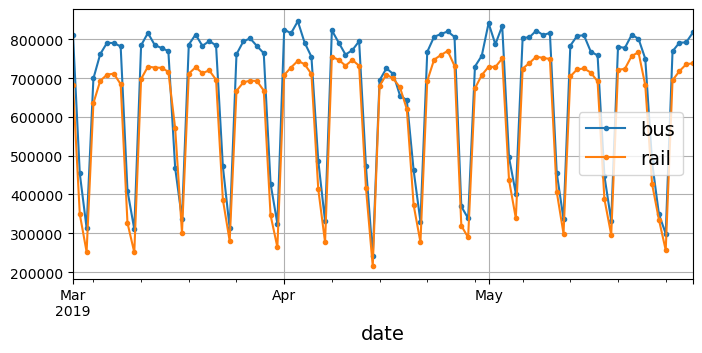

In [27]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
#save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

# Preparing data for ML models

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output a single value: the forecast for time step $t + 1$.

In [1]:
import tensorflow as tf

Sample time series

In [11]:
my_series = [0, 1, 2, 3, 4, 5]

## First method: `timeseries_dataset_from_array`

In [ ]:
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)

Each sample in the dataset is a window of length 3, along with its corresponding
target (i.e., the value immediately after the window). The windows are `[0, 1, 2]`, `[1,
2, 3]`, and `[2, 3, 4]`, and their respective targets are 3, 4, and 5. Since there are three
windows in total, which is not a multiple of the batch size, the last batch only contains
one window instead of two.

In [13]:
list(my_dataset)

2025-01-13 14:02:34.290202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

## Second method: `window`

### Illustrating the concept

This is more flexible.

Here we create windows of size 4 from a list of 6 integers.

In [15]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-01-13 14:26:24.879415: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-13 14:26:24.882901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-13 14:26:24.885123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-13 14:26:24.886430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-13 14:26:24.887674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-13 14:26:24.889724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-13 14:26:24.891

Trick to only output windows with the specified size (i.e. 4) and with the desired batch size (4)

In [19]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))

for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


2025-01-13 14:40:11.589516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Helper function

In [20]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

Split each window into inputs and targets, using the `map()` method.
We can also group the resulting windows into batches of size 2:

In [22]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

list(dataset.batch(2))

2025-01-13 14:47:24.111379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

## Split into training, validation and test

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [28]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Blue is training, orange if validation, green is test

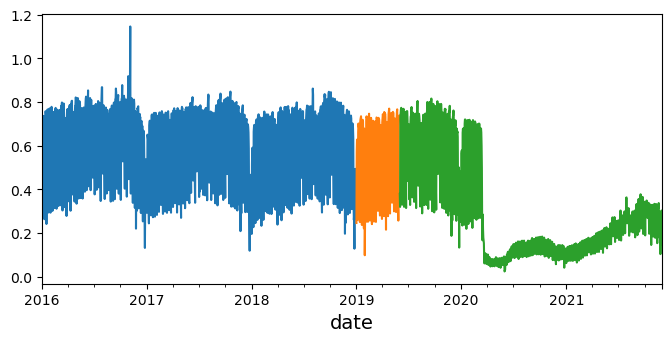

In [37]:
rail_train.plot(figsize=(8, 3.5))
rail_valid.plot()
rail_test.plot()
plt.show()

Next, let’s use `timeseries_dataset_from_array()` to create datasets for training and
validation. Since gradient descent expects the instances in the training set to be
independent and identically distributed (IID), as we saw in Chapter 4, we must set the
argument `shuffle=True` to shuffle the training windows (but not their contents):

In [29]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Linear model

In [38]:
tf.random.set_seed(42)

This code defines a very simple neural network with:

- **1 input layer**: The input layer expects vectors of size `seq_length`.
- **1 dense (fully connected) layer**: This layer produces a single scalar value as output, which is a linear combination of the input values plus a bias, followed by an optional activation function (default is none, so it’s linear).

If the input to the `Dense` layer is a vector **`x`** of size `seq_length`, the output is computed as $y = xW + b$ where:
- **`x`**: Input vector of shape `(seq_length,)`.
- **`W`**: Weight matrix of shape `(seq_length, 1)`, learned during training.
- **`b`**: Bias term of shape `(1,)`, also learned during training.
- **`y`**: Output scalar value of shape `(1,)`.

This type of model is typically used for **very simple tasks**, such as:
1. **Linear regression**: Predicting a continuous value from the input.
2. **Binary classification**: If paired with an activation function like `sigmoid`, the output could represent the probability of a binary class.

In [139]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,)),  # Define the input shape
    tf.keras.layers.Dense(1)
])

In [140]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1961 - mae: 0.5028 - val_loss: 0.0132 - val_mae: 0.1250
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - mae: 0.1393 - val_loss: 0.0067 - val_mae: 0.0850
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mae: 0.0972 - val_loss: 0.0070 - val_mae: 0.0864
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mae: 0.0956 - val_loss: 0.0047 - val_mae: 0.0659
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mae: 0.0898 - val_loss: 0.0044 - val_mae: 0.0642
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - mae: 0.0793 - val_loss: 0.0043 - val_mae: 0.0638
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0769 - val_loss: 0.0058 - val_mae: 0.0824
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - mae: 0.0810 - val_loss: 0.0040 - val_mae: 0.0598
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.005

In [141]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - mae: 0.0388


37642.113864421844

In [142]:
model.evaluate(valid_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - mae: 0.0388


[0.0022571056615561247, 0.037642113864421844]

Better than naive forecasting, worse than SARIMA.

## Forecast 1: predict one point at a time

For every prediction, uses the observations. No cumulative error involved.

In [143]:
ts_val=rail_valid.to_numpy()

In [144]:
y_preds = []
t = []
for i, today in enumerate(ts_val[seq_length+1:]):
    # input array that will be used to compute the forecast
    t_in=tf.expand_dims(ts_val[i:seq_length+i], axis=0)
    
    y_pred = model(t_in)
    y_preds.append(y_pred.numpy().item())
    # put timestamp manually (slow) to make sure we are getting things right
    t.append(rail_valid.index[seq_length+1+i]) 

In [151]:
# convert to pandas series
y_predsP = pd.Series(y_preds, index=t)
# this is the alternate way of getting the time stamps, with less code
#y_predsP = pd.Series(y_preds, index=pd.date_range(rail_valid.index[seq_length+1], rail_valid.index[-1]))

mae1 = (y_preds - rail_valid[t]).abs().mean()*1e6

In [152]:
mae1

133763.31918925425

Displays the forecasts

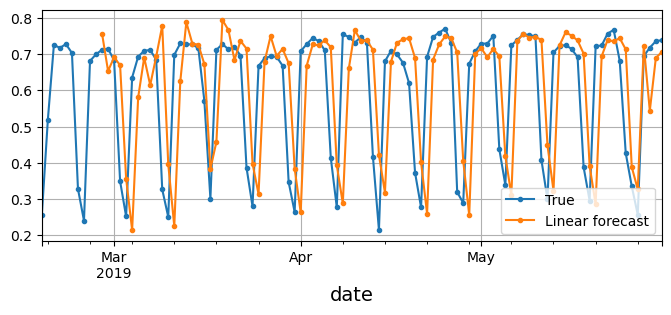

In [155]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_predsP.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_predsP, marker=".", label="Linear forecast")
plt.legend(fontsize=10, loc='lower right')
plt.show()

## Forecast 2: whole future is unknown

We start with a given point, and from there we predict the future one step at a time. I expect considerable drifting as time advances.

In [157]:
y_preds = []
t = []
# input array that will be used to compute the forecast
# some care is needed to update the sliding window. here is how we initialize it
t_in=ts_val[0:seq_length]

for i, today in enumerate(ts_val[seq_length+1:]):
    t_in_tf=tf.expand_dims(t_in, axis=0)
    y_pred = model(t_in_tf)
    
    y_preds.append(y_pred.numpy().item())
    # put timestamp manually (slow) to make sure we are getting things right
    t.append(rail_valid.index[seq_length+1+i]) 

    # updates the sliding window
    t_in=np.roll(t_in,-1)
    t_in[-1]=y_pred

In [158]:
# convert to pandas series
y_predsP = pd.Series(y_preds, index=t)

mae2 = (y_preds - rail_valid[t]).abs().mean()*1e6

In [160]:
mae2

135921.33919878205

Displays the forecasts

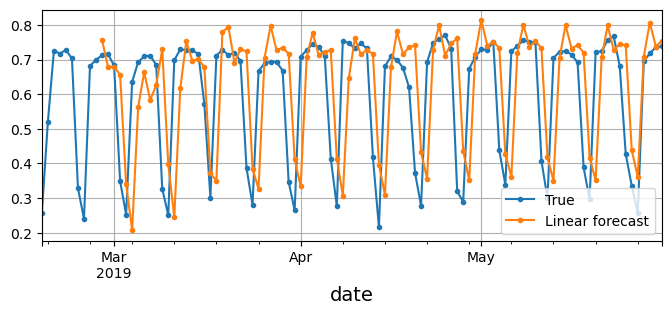

In [159]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_predsP.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_predsP, marker=".", label="Linear forecast")
plt.legend(fontsize=10, loc='lower right')
plt.show()

## Analysis

**Abysmal performance at troughs** 

I suspect that when starting the forecast at a given time, the model does not know at what point in the period it began. It learned the seasonality, but is helpless about what to do at a random starting time. So I suspect that if we initialize the forecast precisely at the start of the week, the MAE will hugely improve.

**Same forecast with the two techniques**

It does not matter much whether we forecast using the actual data, one point at a time, or whether we start with the 56 first observations and from there let the model run by itself.